In [161]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(0)

In [162]:
class DeepSetNetwork(nn.Module):
    def __init__(self, input_dim):
        super(DeepSetNetwork, self).__init__()
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.init_weights()

    def init_weights(self):
        alpha, gamma = np.random.rand() * 2 - 1, np.random.rand() * 2 - 1
        weights = alpha * torch.eye(self.linear1.weight.shape[0]) + gamma * (torch.ones_like(self.linear1.weight))
        self.linear1.weight.data = weights
        self.linear1.bias.data = torch.zeros_like(self.linear1.bias)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = torch.sum(x, dim=1)
        return x.view(-1, 1)

In [163]:
def sample_from_cube(npoints, ndim, side_length):
    vec = np.random.uniform(-side_length, side_length, (npoints, ndim))
    return torch.Tensor(vec)

def get_jacobians(points, model):
    """
    Compute the Jacobian of the model outputs with respect to its inputs for each input point.
    
    :param points: A tensor of shape (N, M) containing N points of dimension M.
    :param model: A PyTorch model that accepts inputs of shape (N, M) and outputs a tensor of shape (N, 1).
    :returns: A tensor of Jacobians of shape (N, M), where each row corresponds to the Jacobian of the model output with respect to the input point.
    """
    points.requires_grad = True
    output = model(points)
    output.backward(torch.ones_like(output))
    jacobians = points.grad
    return jacobians

def remove_duplicates(array):
    return np.unique(array, axis=0)

In [164]:
def sort_point_components(tensor):
    return torch.sort(tensor, dim=1).values

In [165]:
import math

def estimate_linear_regions(model, radius, n_points, point_dim):
    points = sample_from_cube(npoints=n_points, ndim=point_dim, side_length=radius)
    jacobians = get_jacobians(points, model).detach().numpy()
    unique_jacobians = remove_duplicates(np.around(jacobians, 10))
    return unique_jacobians.shape[0]


def estimate_linear_regions_using_fundamental_domain(model, radius, n_points, point_dim):
    points = sample_from_cube(npoints=n_points, ndim=point_dim, side_length=radius)
    points = sort_point_components(points)
    jacobians = get_jacobians(points, model).detach().numpy()
    unique_jacobians = remove_duplicates(np.around(jacobians, 10))
    total = 0
    for jacobian in unique_jacobians:
        counts = np.unique(jacobian, return_counts=True)[1]
        total += math.factorial(point_dim) / np.prod([math.factorial(count) for count in counts])
    return total

In [166]:
import matplotlib.pyplot as plt

def run_experiment(num_models, point_dim, search_radius, base_num_points):
    num_points_adjusted_for_dimension = base_num_points ** point_dim
    print(f"Running experiment with {num_models} models, {point_dim} input dimension, search radius {search_radius}, and {num_points_adjusted_for_dimension} points.")
    models = [DeepSetNetwork(point_dim) for _ in range(num_models)]
    all_ratios = []
    for i, model in enumerate(models):
        print(f"Model {i}")
        regular_sampling = estimate_linear_regions(model, search_radius, num_points_adjusted_for_dimension, point_dim)
        fundamental_domain_sampling = estimate_linear_regions_using_fundamental_domain(model, search_radius, num_points_adjusted_for_dimension//(math.factorial(point_dim)), point_dim)
        ratio = fundamental_domain_sampling / regular_sampling
        all_ratios.append(ratio)
        print(f"Regular: {regular_sampling}, Fundamental domain: {fundamental_domain_sampling}, Ratio: {ratio}")

    average_ratio = sum(all_ratios) / num_models
    print(f"Average ratio: {average_ratio}")

    return all_ratios

NUM_MODELS = 10
point_dim_to_ratios = {}
for point_dim in range(2, 7):
    point_dim_to_ratios[point_dim] = run_experiment(num_models=NUM_MODELS, point_dim=point_dim, search_radius=5, base_num_points=10)

Running experiment with 10 models, 2 input dimension, search radius 5, and 100 points.
Model 0
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 1
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 2
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 3
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 4
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 5
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 6
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 7
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 8
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Model 9
Regular: 4, Fundamental domain: 4.0, Ratio: 1.0
Average ratio: 1.0
Running experiment with 10 models, 3 input dimension, search radius 5, and 1000 points.
Model 0
Regular: 8, Fundamental domain: 8.0, Ratio: 1.0
Model 1
Regular: 6, Fundamental domain: 6.0, Ratio: 1.0
Model 2
Regular: 8, Fundamental domain: 8.0, Ratio: 1.0
Model 3
Regular: 8, Fundamental domain: 8.0, Ratio: 1.0
Model 4
Regular: 8, Fu

Input dimension 2: mean 1.0, variance 0.0
Input dimension 3: mean 1.025, variance 0.005625
Input dimension 4: mean 1.18125, variance 0.10269531250000001
Input dimension 5: mean 1.2601293103448277, variance 0.2584934694560048
Input dimension 6: mean 2.3078125, variance 1.0465844726562499


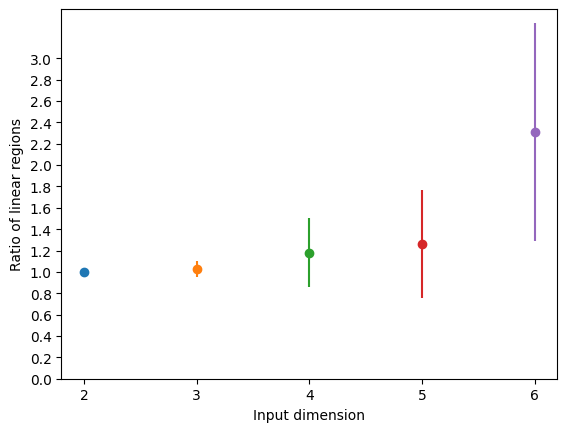

In [167]:
for k, v in point_dim_to_ratios.items():
    mean = sum(v) / len(v)
    variance = sum([(x - mean) ** 2 for x in v]) / len(v)
    print(f"Input dimension {k}: mean {mean}, variance {variance}")
    plt.errorbar(k, mean, yerr=variance**0.5, fmt='o')
plt.yticks(np.arange(0, 3.2, 0.2))
plt.xticks(range(2, 7))
plt.xlabel("Input dimension")
plt.ylabel("Ratio of linear regions")
plt.show()